# XGBoost Article

The data here is taken form the Data Hackathon3.x - http://datahack.analyticsvidhya.com/contest/data-hackathon-3x

## Import Libraries:

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb   #CV 
from xgboost.sklearn import XGBClassifier  #Sklearn's Grid search with parallel processing
from sklearn import cross_validation, metrics   
from sklearn.grid_search import GridSearchCV   #调参参数搜索

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams    
rcParams['figure.figsize'] = 12, 4

## Load Data:

The data has gone through following pre-processing:
1. City variable dropped because of too many categories
2. DOB converted to Age | DOB dropped
3. EMI_Loan_Submitted_Missing created which is 1 if EMI_Loan_Submitted was missing else 0 | EMI_Loan_Submitted dropped
4. EmployerName dropped because of too many categories
5. Existing_EMI imputed with 0 (median) - 111 values were missing
6. Interest_Rate_Missing created which is 1 if Interest_Rate was missing else 0 | Interest_Rate dropped 
7. Lead_Creation_Date dropped because made little intuitive impact on outcome
8. Loan_Amount_Applied, Loan_Tenure_Applied imputed with missing
9. Loan_Amount_Submitted_Missing created which is 1 if Loan_Amount_Submitted was missing else 0 | Loan_Amount_Submitted dropped 
10. Loan_Tenure_Submitted_Missing created which is 1 if Loan_Tenure_Submitted was missing else 0 | Loan_Tenure_Submitted dropped 
11. LoggedIn, Salary_Account removed
12. Processing_Fee_Missing created which is 1 if Processing_Fee was missing else 0 | Processing_Fee dropped
13. Source - top 2 kept as is and all others combined into different category
14. Numerical and One-Hot-Coding performed

In [13]:
train = pd.read_csv('train_modified.csv')
test = pd.read_csv('test_modified.csv')

In [14]:
train.shape, test.shape

((87020, 51), (37717, 50))

In [15]:
target='Disbursed'
IDcol = 'ID'

In [17]:
train['Disbursed'].value_counts()

0.0    85747
1.0     1273
Name: Disbursed, dtype: int64

## Define a function for modeling and cross-validation

This function will do the following:
1. fit the model
2. determine training accuracy
3. determine training AUC
4. determine testing AUC
5. update n_estimators with cv function of xgboost package
6. plot Feature Importance 

In [18]:
def modelfit(alg, dtrain, dtest, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)  
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        print(cvresult.shape[0])
        alg.set_params(n_estimators=cvresult.shape[0])  #n_estimators 弱分类器个数
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])  
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]  #预测为1的概率
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
                
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False) 
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    # xgboost's sklearn wrapper doesn,t have a “feature_importances” metric but a get_fscore() function which does the same job.

# General Approach for Parameter Tuning
We will use an approach similar to that of GBM here. The various steps to be performed are:
1.Choose a relatively high learning rate. Generally a learning rate of 0.1 works but somewhere between 0.05 to 0.3 should work for different problems. Determine the optimum number of trees for this learning rate. XGBoost has a very useful function called as “cv” which performs cross-validation at each boosting iteration and thus returns the optimum number of trees required.

2.Tune tree-specific parameters ( max_depth, min_child_weight, gamma, subsample, colsample_bytree) for decided learning rate and number of trees. Note that we can choose different parameters to define a tree and I’ll take up an example here.

3.Tune regularization parameters (lambda, alpha) for xgboost which can help reduce model complexity and enhance performance.

4.Lower the learning rate and decide the optimal parameters .
Let us look at a more detailed step by step approach.

# Step 1- Find the number of estimators for a high learning rate

112

Model Report
Accuracy : 0.9854
AUC Score (Train): 0.891681


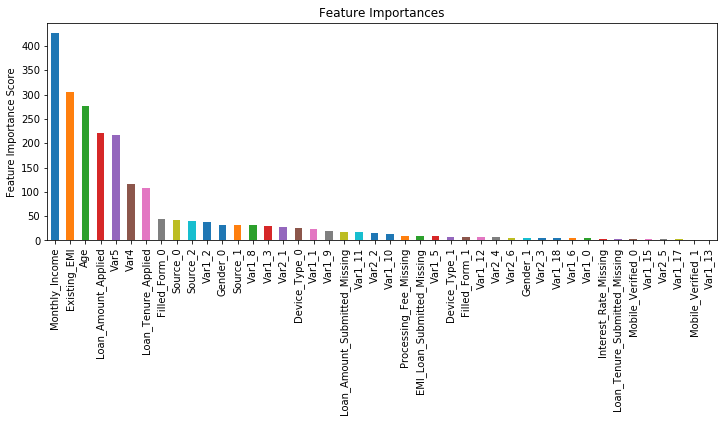

In [19]:
#choose all predictors(属性) except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
        learning_rate =0.1, #hig
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb1, train, test, predictors) 

In [22]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test1 = {
    'max_depth':list(range(3,10,2)),
    'min_child_weight':list(range(1,6,2))
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=128, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=128, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_depth': [3, 5, 7, 9], 'min_child_weight': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [23]:
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.83712, std: 0.00858, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.83713, std: 0.00877, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.83659, std: 0.00776, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.84054, std: 0.00684, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.84033, std: 0.00557, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.84007, std: 0.00498, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.83713, std: 0.00594, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.83640, std: 0.00672, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.83608, std: 0.00554, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.83065, std: 0.00654, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.83136, std: 0.00571, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.83312, std: 0.00674, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_child_weight': 1

In [24]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test2 = {
    'max_depth':[4,5,6],
    'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=128, max_depth=5,
                                        min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=2, missing=None, n_estimators=128, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_depth': [4, 5, 6], 'min_child_weight': [4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [25]:
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.83976, std: 0.00623, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: 0.83930, std: 0.00714, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: 0.83942, std: 0.00681, params: {'max_depth': 4, 'min_child_weight': 6},
  mean: 0.84110, std: 0.00543, params: {'max_depth': 5, 'min_child_weight': 4},
  mean: 0.84007, std: 0.00498, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.83938, std: 0.00568, params: {'max_depth': 5, 'min_child_weight': 6},
  mean: 0.84046, std: 0.00287, params: {'max_depth': 6, 'min_child_weight': 4},
  mean: 0.83857, std: 0.00502, params: {'max_depth': 6, 'min_child_weight': 5},
  mean: 0.83846, std: 0.00615, params: {'max_depth': 6, 'min_child_weight': 6}],
 {'max_depth': 5, 'min_child_weight': 4},
 0.8411026511775098)

In [26]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test2b = {
    'min_child_weight':[6,8,10,12]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=128, max_depth=5,
                                        min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2b.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=2, missing=None, n_estimators=128, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'min_child_weight': [6, 8, 10, 12]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [27]:
gsearch2b.grid_scores_, gsearch2b.best_params_, gsearch2b.best_score_

([mean: 0.83938, std: 0.00568, params: {'min_child_weight': 6},
  mean: 0.83888, std: 0.00574, params: {'min_child_weight': 8},
  mean: 0.84025, std: 0.00680, params: {'min_child_weight': 10},
  mean: 0.83876, std: 0.00650, params: {'min_child_weight': 12}],
 {'min_child_weight': 10},
 0.8402546402248386)

In [28]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test3 = {
    'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=128, max_depth=5,
                                        min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=5, missing=None, n_estimators=128, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [29]:
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.84007, std: 0.00498, params: {'gamma': 0.0},
  mean: 0.84003, std: 0.00547, params: {'gamma': 0.1},
  mean: 0.84081, std: 0.00591, params: {'gamma': 0.2},
  mean: 0.84070, std: 0.00465, params: {'gamma': 0.3},
  mean: 0.84111, std: 0.00444, params: {'gamma': 0.4}],
 {'gamma': 0.4},
 0.8411069059775655)

142

Model Report
Accuracy : 0.9854
AUC Score (Train): 0.896256


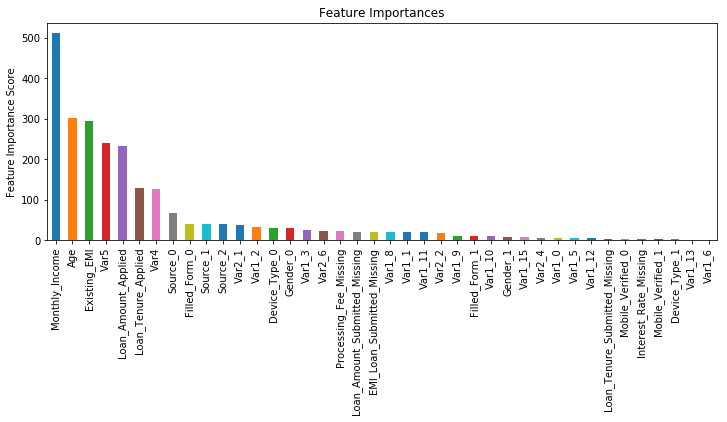

In [30]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb2 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=5,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb2, train, test, predictors)

Tune subsample and colsample_bytree

In [53]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test4 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=117, max_depth=5,
                                        min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=5, missing=None, n_estimators=117, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [54]:
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.83793, std: 0.00851, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.83847, std: 0.00728, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.83719, std: 0.00761, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.84038, std: 0.00637, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.83959, std: 0.00656, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.83999, std: 0.00795, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.83868, std: 0.00713, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.84000, std: 0.00746, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.83827, std: 0.00775, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.84050, std: 0.00583, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.83976, std: 0.00558, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.84034, std: 0.00784, params: {'colsample_bytree': 0.8, 'subsample'

tune subsample:

In [55]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test5 = {
    'subsample':[i/100.0 for i in range(80,100,5)],
    'colsample_bytree':[i/100.0 for i in range(70,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=117, max_depth=5,
                                        min_child_weight=5, gamma=0, subsample=0.9, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=5, missing=None, n_estimators=117, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.9),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'subsample': [0.8, 0.85, 0.9, 0.95], 'colsample_bytree': [0.7, 0.75, 0.8, 0.85]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [56]:
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: 0.83868, std: 0.00713, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.84039, std: 0.00681, params: {'colsample_bytree': 0.7, 'subsample': 0.85},
  mean: 0.84000, std: 0.00746, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.84063, std: 0.00564, params: {'colsample_bytree': 0.7, 'subsample': 0.95},
  mean: 0.83816, std: 0.00672, params: {'colsample_bytree': 0.75, 'subsample': 0.8},
  mean: 0.83905, std: 0.00615, params: {'colsample_bytree': 0.75, 'subsample': 0.85},
  mean: 0.83837, std: 0.00755, params: {'colsample_bytree': 0.75, 'subsample': 0.9},
  mean: 0.84006, std: 0.00668, params: {'colsample_bytree': 0.75, 'subsample': 0.95},
  mean: 0.83976, std: 0.00558, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.83877, std: 0.00807, params: {'colsample_bytree': 0.8, 'subsample': 0.85},
  mean: 0.84034, std: 0.00784, params: {'colsample_bytree': 0.8, 'subsample': 0.9},
  mean: 0.84030, std: 0.00626, params: {'colsample_bytree': 0.8, 's

Got the same value as assument and no change requried.

Try regularization:

In [57]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test6 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=117, max_depth=5,
                                        min_child_weight=5, gamma=0, subsample=0.9, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=5, missing=None, n_estimators=117, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.9),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [58]:
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.84034, std: 0.00784, params: {'reg_alpha': 1e-05},
  mean: 0.84003, std: 0.00785, params: {'reg_alpha': 0.01},
  mean: 0.84001, std: 0.00790, params: {'reg_alpha': 0.1},
  mean: 0.84056, std: 0.00746, params: {'reg_alpha': 1},
  mean: 0.81384, std: 0.01455, params: {'reg_alpha': 100}],
 {'reg_alpha': 1},
 0.8405613469948733)

In [59]:
#Grid seach on subsample and max_features
#Choose all predictors except target & IDcols
param_test7 = {
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=117, max_depth=5,
                                        min_child_weight=5, gamma=0, subsample=0.9, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch7.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=5, missing=None, n_estimators=117, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.9),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [60]:
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

([mean: 0.84034, std: 0.00784, params: {'reg_alpha': 0},
  mean: 0.84041, std: 0.00796, params: {'reg_alpha': 0.001},
  mean: 0.84033, std: 0.00765, params: {'reg_alpha': 0.005},
  mean: 0.84003, std: 0.00785, params: {'reg_alpha': 0.01},
  mean: 0.83929, std: 0.00815, params: {'reg_alpha': 0.05}],
 {'reg_alpha': 0.001},
 0.8404110006081874)

111

Model Report
Accuracy : 0.9854
AUC Score (Train): 0.886209


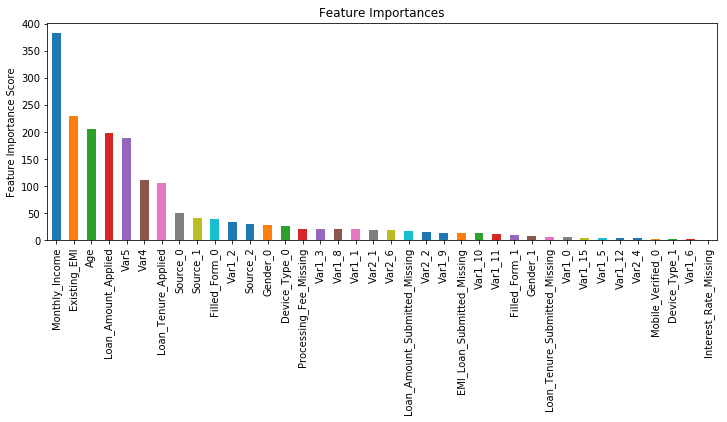

In [62]:
xgb3 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=5,
        gamma=0,
        subsample=0.9,
        colsample_bytree=0.8,
        reg_alpha=0,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb3, train, test, predictors)

1433

Model Report
Accuracy : 0.9854
AUC Score (Train): 0.895844


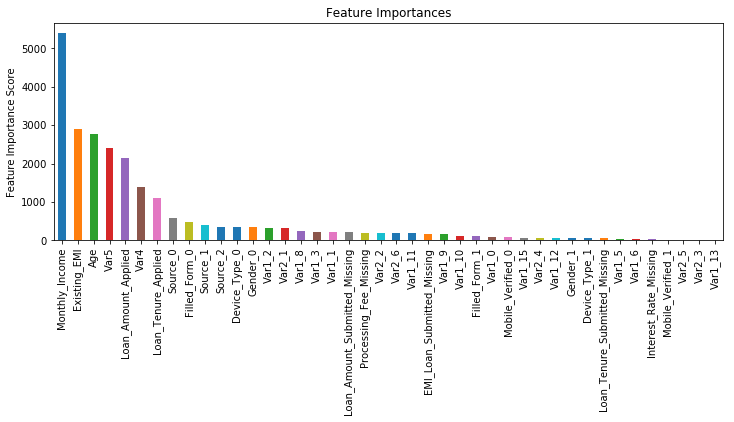

In [50]:
xgb4 = XGBClassifier(
        learning_rate =0.01, #学习率
        n_estimators=5000,   #分类器个数
        max_depth=5,         #树深度
        min_child_weight=5, 
        gamma=0,
        subsample=0.9,
        colsample_bytree=0.8,
        reg_alpha=0,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb4, train, test, predictors)